## 0. Libarary 불러오기 및 경로설정

In [47]:
import os
import glob
import pandas as pd
import numpy as np
import time
import datetime
from pytz import timezone

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from PIL import Image
from copy import deepcopy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.optim import lr_scheduler

from pytorch_pretrained_vit import ViT

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print('PyTorch version: {}'.format(torch.__version__))

PyTorch version: 1.7.1


In [4]:
# Set random seed
SEED = 2021
# random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [49]:
class cfg:
    train_dir = '/opt/ml/input/data/train'
    img_dir = f'{train_dir}/images'
    df_path = f'{train_dir}/train_with_label.csv'
    
    model_save_path = '/opt/ml/code/model'
    sumission_save_path = '/opt/ml/code/sumission'
    
    test_dir = '/opt/ml/input/data/eval'
    submission_dir = f'''{sumission_save_path}/
        {datetime.datetime.today().astimezone(timezone("Asia/Seoul")).strftime("%Y-%m-%d")}'''

In [6]:
if not os.path.exists(cfg.submission_dir):
    os.mkdir(cfg.submission_dir)

In [7]:
## HYPER PARAMETER 정의
EPOCHS = 50
BATCH_SIZE = 200
LEARNING_RATE = 0.001
CLASS_NUM = 18
IMAGE_SIZE = 197
PATIENCE = 7
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is using!')

cuda:0 is using!


## 1. Pretrained Model 불러오기

In [8]:
vit = ViT('B_16', image_size=IMAGE_SIZE, pretrained=True)
print('네트워크 필요 입력 채널 개수', vit.patch_embedding.weight.shape[1])
print('네트워크 출력 채널 개수 (예측 class type 개수)', vit.fc.weight.shape[0])
print(vit)

Resized positional embeddings from torch.Size([1, 197, 768]) to torch.Size([1, 145, 768])
Loaded pretrained weights.
네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 21843
ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_feat

In [9]:
# target model의 출력 크기를 변경하여 줍니다.
vit.fc = torch.nn.Linear(in_features=768, out_features=CLASS_NUM, bias=True)

# 새롭게 넣은 네트워크 가중치를 xavier uniform으로 초기화
torch.nn.init.xavier_uniform_(vit.fc.weight)
stdv = 1.0/np.sqrt(768)
vit.fc.bias.data.uniform_(-stdv, stdv)

print('네트워크 출력 채널 개수 (예측 class type 개수)', vit.fc.weight.shape[0])

네트워크 출력 채널 개수 (예측 class type 개수) 18


for param in efficientnet.parameters():
    param.requires_grad = False

for param in efficientnet._fc.parameters():
    param.requires_grad = True

### requires_grad = False 적용 됐는지 확인

list(efficientnet._conv_stem.parameters())[0]

list(efficientnet._fc.parameters())[0]

## 2. Train Dataset 정의

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, transform):
        self.img_paths = df['image_path']
        self.transform = transform
        self.y = df['target']

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.img_paths.iloc[idx])
        label = self.y.iloc[idx]

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

In [11]:
df = pd.read_csv(os.path.join(cfg.train_dir, 'train_with_label.csv'))

In [12]:
df.head()

,mask,path,image_path,age,gender,age_band,target
0,Incorrect,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,45,female,>= 30 and < 60,10
1,Wear,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,45,female,>= 30 and < 60,4
2,Wear,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,45,female,>= 30 and < 60,4
3,Not Wear,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,45,female,>= 30 and < 60,16
4,Wear,000001_female_Asian_45,/opt/ml/input/data/train/images/000001_female_...,45,female,>= 30 and < 60,4


In [13]:
train_df, valid_df = train_test_split(df, test_size=0.3, stratify=df['target'], shuffle=True, random_state=2021)
train_df.shape, valid_df.shape

((13230, 7), (5670, 7))

# train_df 이미지의 pixel 값의 mean & std

images_info = {'height': [], 'width': [], 'means': [], 'stds': []}
for i, image_path in enumerate(tqdm(train_df.image_path)):
    img = np.array(Image.open(image_path))
    h, w, _ = img.shape
    images_info['height'].append(h)
    images_info['width'].append(w)
    images_info['means'].append(img.mean(axis=(0, 1)))
    images_info['stds'].append(img.std(axis=(0, 1)))

print('Train Data')

print(f'Minimum height for dataset is {np.min(images_info["height"])}')
print(f'Maximum height for dataset is {np.max(images_info["height"])}')
print(f'Average height for dataset is {int(np.mean(images_info["height"]))}')
print(f'Minimum width for dataset is {np.min(images_info["width"])}')
print(f'Maximum width for dataset is {np.max(images_info["width"])}')
print(f'Average width for dataset is {int(np.mean(images_info["width"]))}')

print(f'RGB Mean: {np.mean(images_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(images_info["stds"], axis=0) / 255.}')

In [14]:
mean_list = [0.56074416, 0.52454219, 0.50188343]
std_list = [0.23304677, 0.24291714, 0.24565602]

In [15]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomChoice([transforms.ColorJitter(brightness=(0.2, 3)),
                             transforms.ColorJitter(contrast=(0.2, 3)),
                             transforms.ColorJitter(saturation=(0.2, 3)),
                             transforms.ColorJitter(hue=(-0.3, 0.3)),
                            ]),
    transforms.ToTensor(),
    transforms.Normalize(mean_list, 
                         std_list)
])

In [16]:
train_dataset = MyDataset(train_df, transform)
valid_dataset = MyDataset(valid_df, transform=transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean_list, 
                         std_list)
]))
len(train_dataset), len(valid_dataset)

(13230, 5670)

## 3. Train DataLoader 정의

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=4)

## 4. Criterion & Optimizer & lr_scheduler & EarlyStopping 정의

In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1_score_max = -np.Inf

    def __call__(self, val_f1_score, model):

        score = val_f1_score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
            self.counter = 0

    def save_checkpoint(self, val_f1_score, model):
        '''Saves model when validation f1_score increase.'''
        if self.verbose:
            print(f'Validation f1_score increased ({self.val_f1_score_max:.6f} --> {val_f1_score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'{os.path.join(cfg.model_save_path, "VIT")}/checkpoint.pt')
        self.val_f1_score_max = val_f1_score

In [19]:
model = vit.to(device)

# weight = torch.tensor(len(train_df) // train_df.target.value_counts()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
earlystop = EarlyStopping(patience=PATIENCE, verbose = True)

## 5. Train

In [48]:
time.time()

1629887736.1938424

In [20]:
start = time.time()

train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

best_f1 = 0.0

for epoch in range(1, EPOCHS + 1):
    # Train phase
    model.train()
    
    train_running_loss = 0
    train_running_acc = 0
    train_running_epoch_f1 = 0
    
    pbar = tqdm(train_loader)
    for X_batch, y_batch in pbar:
        pbar.set_description(f'Epoch {epoch}/{EPOCHS} | loss : {train_running_loss:.4f} | F1_score : {train_running_epoch_f1:.4f}')
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.cuda.LongTensor)
        
        optimizer.zero_grad()
        
        y_pred = model.forward(X_batch)
        _, preds = torch.max(y_pred, 1)
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item() / len(y_batch)
        train_running_acc += torch.sum(preds == y_batch.data) / len(y_batch)
        train_running_epoch_f1 += f1_score(preds.cpu().numpy(), 
                                           y_batch.cpu().numpy(), average='macro')
        
    exp_lr_scheduler.step()
    
    train_epoch_loss = train_running_loss / len(train_loader)
    train_epoch_acc = train_running_acc / len(train_loader)
    train_epoch_f1 = train_running_epoch_f1 / len(train_loader)
    
    train_acc_history.append(train_epoch_acc)
    train_loss_history.append(train_epoch_loss)
    
    print(f'Train Loss : {train_epoch_loss:.4f}, Accuracy : {train_epoch_acc:.4f}, F1_score : {train_epoch_f1:.4f}')
    
    # Validation pahse
    model.eval()
    
    valid_running_loss = 0
    valid_running_acc = 0
    valid_running_epoch_f1 = 0
    with torch.no_grad():
        pbar = tqdm(valid_loader)
        for X_batch, y_batch in pbar:
            pbar.set_description(f'Epoch {epoch}/{EPOCHS} | loss : {valid_running_loss:.4f} | F1_score : {valid_running_epoch_f1:.4f}')
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.cuda.LongTensor)
            
            y_pred = model.forward(X_batch)
            _, preds = torch.max(y_pred, 1)
            loss = criterion(y_pred, y_batch)
            
            valid_running_loss += loss.item() / len(y_batch)
            valid_running_acc += torch.sum(preds == y_batch.data) / len(y_batch)
            valid_running_epoch_f1 += f1_score(preds.cpu().numpy(), 
                                           y_batch.cpu().numpy(), average='macro')
            
    valid_epoch_loss = valid_running_loss / len(valid_loader)
    valid_epoch_acc = valid_running_acc / len(valid_loader)
    valid_epoch_f1 = valid_running_epoch_f1 / len(valid_loader)
    
    earlystop(valid_epoch_f1, model)
    
    print(f'Validation Loss : {valid_epoch_loss:.4f}, Accuracy : {valid_epoch_acc:.4f}, F1_score : {valid_epoch_f1:.4f}')   
    
    if valid_epoch_f1 > best_f1:
        best_f1 = valid_epoch_f1
    
    val_acc_history.append(valid_epoch_acc)
    val_loss_history.append(valid_epoch_loss)
    
    if earlystop.early_stop:
        print('Early stopping')
        model.load_state_dict(torch.load(f'{os.path.join(cfg.model_save_path, "VIT")}/checkpoint.pt'))
        break

print('Best Validation F1_score: {:.4f}'.format(best_f1))
torch.save(model.state_dict(),
           f'{os.path.join(cfg.model_save_path, "VIT")}/best_model_{best_f1:.4f}.pt')
print('학습 종료!')
end = time.time()
print(f'학습 총 걸린 시간 : {end - start:.2f}')

Epoch 1/50 | loss : 0.7767 | F1_score : 2.8308: 100%|██████████| 67/67 [01:40<00:00,  1.50s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0127, Accuracy : 0.2360, F1_score : 0.0431


Epoch 1/50 | loss : 0.3391 | F1_score : 0.7174: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (-inf --> 0.026092).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0129, Accuracy : 0.2190, F1_score : 0.0261


Epoch 2/50 | loss : 0.7013 | F1_score : 5.6785: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0114, Accuracy : 0.3158, F1_score : 0.0880


Epoch 2/50 | loss : 0.2439 | F1_score : 5.1207: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (0.026092 --> 0.183120).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0093, Accuracy : 0.3969, F1_score : 0.1831


Epoch 3/50 | loss : 0.5018 | F1_score : 19.2084: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0079, Accuracy : 0.5084, F1_score : 0.2936


Epoch 3/50 | loss : 0.2258 | F1_score : 9.7023: 100%|██████████| 29/29 [00:16<00:00,  1.78it/s]


Validation f1_score increased (0.183120 --> 0.346454).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0085, Accuracy : 0.4918, F1_score : 0.3465


Epoch 4/50 | loss : 0.3489 | F1_score : 30.7605: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0056, Accuracy : 0.6468, F1_score : 0.4668


Epoch 4/50 | loss : 0.0935 | F1_score : 16.3250: 100%|██████████| 29/29 [00:16<00:00,  1.78it/s]


Validation f1_score increased (0.346454 --> 0.583731).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0035, Accuracy : 0.7703, F1_score : 0.5837


Epoch 5/50 | loss : 0.2483 | F1_score : 37.9625: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0040, Accuracy : 0.7410, F1_score : 0.5753


Epoch 5/50 | loss : 0.0802 | F1_score : 18.1374: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]


Validation f1_score increased (0.583731 --> 0.645787).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0030, Accuracy : 0.8031, F1_score : 0.6458


Epoch 6/50 | loss : 0.2158 | F1_score : 41.3954: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0035, Accuracy : 0.7769, F1_score : 0.6276


Epoch 6/50 | loss : 0.0718 | F1_score : 19.1551: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (0.645787 --> 0.684926).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0027, Accuracy : 0.8179, F1_score : 0.6849


Epoch 7/50 | loss : 0.2012 | F1_score : 42.7799: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0034, Accuracy : 0.7908, F1_score : 0.6476


Epoch 7/50 | loss : 0.0635 | F1_score : 20.3314: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (0.684926 --> 0.719222).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0026, Accuracy : 0.8428, F1_score : 0.7192


Epoch 8/50 | loss : 0.1274 | F1_score : 49.2639: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0022, Accuracy : 0.8660, F1_score : 0.7445


Epoch 8/50 | loss : 0.0480 | F1_score : 21.2494: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (0.719222 --> 0.758460).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0019, Accuracy : 0.8770, F1_score : 0.7585


Epoch 9/50 | loss : 0.1023 | F1_score : 51.3632: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0018, Accuracy : 0.8872, F1_score : 0.7771


Epoch 9/50 | loss : 0.0464 | F1_score : 21.4790: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (0.758460 --> 0.767736).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0017, Accuracy : 0.8799, F1_score : 0.7677


Epoch 10/50 | loss : 0.0969 | F1_score : 51.9431: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0018, Accuracy : 0.8918, F1_score : 0.7838


Epoch 10/50 | loss : 0.0429 | F1_score : 21.8640: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (0.767736 --> 0.781434).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0016, Accuracy : 0.8909, F1_score : 0.7814


Epoch 11/50 | loss : 0.0882 | F1_score : 52.9698: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0014, Accuracy : 0.9049, F1_score : 0.8029


Epoch 11/50 | loss : 0.0409 | F1_score : 22.4666: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]


Validation f1_score increased (0.781434 --> 0.805703).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0015, Accuracy : 0.8976, F1_score : 0.8057


Epoch 12/50 | loss : 0.0824 | F1_score : 54.1213: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0013, Accuracy : 0.9132, F1_score : 0.8212


Epoch 12/50 | loss : 0.0397 | F1_score : 22.1648: 100%|██████████| 29/29 [00:16<00:00,  1.78it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0016, Accuracy : 0.8945, F1_score : 0.7908


Epoch 13/50 | loss : 0.0728 | F1_score : 55.9167: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0011, Accuracy : 0.9239, F1_score : 0.8482


Epoch 13/50 | loss : 0.0393 | F1_score : 22.4690: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0015, Accuracy : 0.9005, F1_score : 0.8033


Epoch 14/50 | loss : 0.0700 | F1_score : 55.2013: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0012, Accuracy : 0.9248, F1_score : 0.8372


Epoch 14/50 | loss : 0.0389 | F1_score : 22.4837: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7
Validation Loss : 0.0015, Accuracy : 0.8999, F1_score : 0.7986


Epoch 15/50 | loss : 0.0616 | F1_score : 56.8848: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0010, Accuracy : 0.9359, F1_score : 0.8607


Epoch 15/50 | loss : 0.0366 | F1_score : 22.8658: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]


Validation f1_score increased (0.805703 --> 0.822811).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0013, Accuracy : 0.9119, F1_score : 0.8228


Epoch 16/50 | loss : 0.0579 | F1_score : 56.9807: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9391, F1_score : 0.8638


Epoch 16/50 | loss : 0.0360 | F1_score : 23.0272: 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]


Validation f1_score increased (0.822811 --> 0.825254).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0014, Accuracy : 0.9115, F1_score : 0.8253


Epoch 17/50 | loss : 0.0595 | F1_score : 56.6198: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0010, Accuracy : 0.9360, F1_score : 0.8591


Epoch 17/50 | loss : 0.0355 | F1_score : 22.7593: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0014, Accuracy : 0.9153, F1_score : 0.8142


Epoch 18/50 | loss : 0.0569 | F1_score : 56.8246: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0010, Accuracy : 0.9395, F1_score : 0.8610


Epoch 18/50 | loss : 0.0352 | F1_score : 22.7572: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0013, Accuracy : 0.9155, F1_score : 0.8159


Epoch 19/50 | loss : 0.0552 | F1_score : 57.9466: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0010, Accuracy : 0.9421, F1_score : 0.8754


Epoch 19/50 | loss : 0.0350 | F1_score : 23.1034: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7
Validation Loss : 0.0014, Accuracy : 0.9145, F1_score : 0.8248


Epoch 20/50 | loss : 0.0558 | F1_score : 57.2259: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9399, F1_score : 0.8690


Epoch 20/50 | loss : 0.0353 | F1_score : 22.8915: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 7
Validation Loss : 0.0013, Accuracy : 0.9144, F1_score : 0.8202


Epoch 21/50 | loss : 0.0553 | F1_score : 57.9526: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9430, F1_score : 0.8749


Epoch 21/50 | loss : 0.0349 | F1_score : 23.0655: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 7
Validation Loss : 0.0013, Accuracy : 0.9138, F1_score : 0.8186


Epoch 22/50 | loss : 0.0530 | F1_score : 58.0409: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0008, Accuracy : 0.9462, F1_score : 0.8812


Epoch 22/50 | loss : 0.0349 | F1_score : 23.1206: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (0.825254 --> 0.827780).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0013, Accuracy : 0.9163, F1_score : 0.8278


Epoch 23/50 | loss : 0.0539 | F1_score : 57.9047: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9445, F1_score : 0.8775


Epoch 23/50 | loss : 0.0345 | F1_score : 23.1281: 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0014, Accuracy : 0.9157, F1_score : 0.8259


Epoch 24/50 | loss : 0.0528 | F1_score : 57.9133: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9454, F1_score : 0.8763


Epoch 24/50 | loss : 0.0348 | F1_score : 23.0346: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0013, Accuracy : 0.9160, F1_score : 0.8234


Epoch 25/50 | loss : 0.0515 | F1_score : 58.4972: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0008, Accuracy : 0.9484, F1_score : 0.8880


Epoch 25/50 | loss : 0.0347 | F1_score : 23.4399: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (0.827780 --> 0.837429).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0013, Accuracy : 0.9153, F1_score : 0.8374


Epoch 26/50 | loss : 0.0535 | F1_score : 58.0098: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9448, F1_score : 0.8791


Epoch 26/50 | loss : 0.0348 | F1_score : 22.9682: 100%|██████████| 29/29 [00:16<00:00,  1.77it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0013, Accuracy : 0.9150, F1_score : 0.8204


Epoch 27/50 | loss : 0.0521 | F1_score : 56.9504: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0008, Accuracy : 0.9432, F1_score : 0.8645


Epoch 27/50 | loss : 0.0349 | F1_score : 22.8984: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0013, Accuracy : 0.9148, F1_score : 0.8168


Epoch 28/50 | loss : 0.0533 | F1_score : 57.6624: 100%|██████████| 67/67 [01:40<00:00,  1.50s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9432, F1_score : 0.8741


Epoch 28/50 | loss : 0.0348 | F1_score : 23.1814: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7
Validation Loss : 0.0013, Accuracy : 0.9145, F1_score : 0.8274


Epoch 29/50 | loss : 0.0508 | F1_score : 58.3614: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9479, F1_score : 0.8835


Epoch 29/50 | loss : 0.0349 | F1_score : 23.1386: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 7
Validation Loss : 0.0013, Accuracy : 0.9154, F1_score : 0.8300


Epoch 30/50 | loss : 0.0512 | F1_score : 58.0607: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0008, Accuracy : 0.9462, F1_score : 0.8797


Epoch 30/50 | loss : 0.0349 | F1_score : 23.4291: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 7
Validation Loss : 0.0013, Accuracy : 0.9154, F1_score : 0.8366


Epoch 31/50 | loss : 0.0518 | F1_score : 57.7706: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9457, F1_score : 0.8748


Epoch 31/50 | loss : 0.0350 | F1_score : 23.3654: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Validation f1_score increased (0.837429 --> 0.839856).  Saving model ...


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Loss : 0.0013, Accuracy : 0.9161, F1_score : 0.8399


Epoch 32/50 | loss : 0.0536 | F1_score : 57.6134: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9456, F1_score : 0.8712


Epoch 32/50 | loss : 0.0349 | F1_score : 23.0147: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0013, Accuracy : 0.9159, F1_score : 0.8214


Epoch 33/50 | loss : 0.0517 | F1_score : 57.7896: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9456, F1_score : 0.8762


Epoch 33/50 | loss : 0.0345 | F1_score : 23.3897: 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0014, Accuracy : 0.9124, F1_score : 0.8318


Epoch 34/50 | loss : 0.0531 | F1_score : 57.2957: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9435, F1_score : 0.8695


Epoch 34/50 | loss : 0.0347 | F1_score : 23.0689: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7
Validation Loss : 0.0013, Accuracy : 0.9154, F1_score : 0.8256


Epoch 35/50 | loss : 0.0520 | F1_score : 57.7607: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9446, F1_score : 0.8745


Epoch 35/50 | loss : 0.0346 | F1_score : 23.2507: 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 7
Validation Loss : 0.0013, Accuracy : 0.9148, F1_score : 0.8289


Epoch 36/50 | loss : 0.0514 | F1_score : 58.5112: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0008, Accuracy : 0.9452, F1_score : 0.8865


Epoch 36/50 | loss : 0.0348 | F1_score : 23.1342: 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 7
Validation Loss : 0.0013, Accuracy : 0.9148, F1_score : 0.8275


Epoch 37/50 | loss : 0.0537 | F1_score : 57.9688: 100%|██████████| 67/67 [01:39<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0009, Accuracy : 0.9442, F1_score : 0.8782


Epoch 37/50 | loss : 0.0347 | F1_score : 23.0367: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]
  0%|          | 0/67 [00:00<?, ?it/s]

EarlyStopping counter: 6 out of 7
Validation Loss : 0.0013, Accuracy : 0.9145, F1_score : 0.8246


Epoch 38/50 | loss : 0.0518 | F1_score : 58.1777: 100%|██████████| 67/67 [01:40<00:00,  1.49s/it]
  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss : 0.0008, Accuracy : 0.9456, F1_score : 0.8820


Epoch 38/50 | loss : 0.0345 | F1_score : 23.0877: 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


EarlyStopping counter: 7 out of 7
Validation Loss : 0.0014, Accuracy : 0.9142, F1_score : 0.8267
Early stopping
Best Validation F1_score: 0.8399
학습 종료!
CPU times: user 38min 12s, sys: 33min 27s, total: 1h 11min 40s
Wall time: 1h 14min 14s


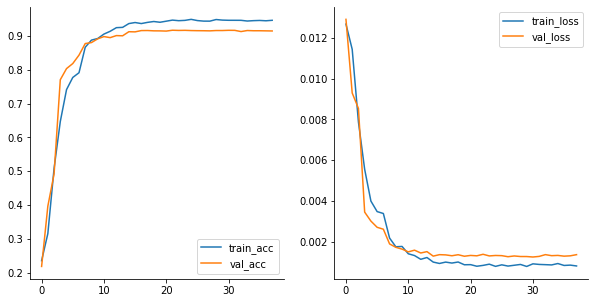

In [32]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_acc_history, label='train_acc')
axes[0].plot(val_acc_history, label='val_acc')
axes[1].plot(train_loss_history, label='train_loss')
axes[1].plot(val_loss_history, label='val_loss')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    
plt.show()

## 6. Inference

In [33]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

## 6.1 Test Dataset 정의

In [34]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean_list, 
                         std_list)
])

In [35]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [44]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
best_model_path = [file for file in glob.glob(os.path.join(cfg.model_save_path, 'VIT/*')) 
                   if 'best_model' in file][0]
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(cfg.submission_dir, 'submission_{}.csv'.format(
    datetime.datetime.today().astimezone(timezone("Asia/Seoul")).strftime('%Y-%m-%d_%H:%M:%S'))), 
                  index=False)
print('test inference is done!')

100%|██████████| 63/63 [00:37<00:00,  1.68it/s]

test inference is done!
